## NOAA daily global weather

<b>Table of Contents</b>

- Overview
- Setup
  - Get authentication token
- Data layers
- Querying the data layers
  - Point query
  - Raster query
- References


### Overview

The Global Data Assimilation System (GDAS), also referred as GFS Reanalysis, is a critical component of the National Center for Environmental Prediction's (NCEP) Global Forecast System (GFS). It integrates a wide variety of observational data into a gridded, three-dimensional model space to initialize weather forecasts. The system incorporates data from diverse sources, including surface observations, balloon measurements, wind profilers, aircraft reports, buoys, radar, and satellites. This assimilation process ensures that the GFS model starts with the most accurate and up-to-date information, enhancing the quality of weather predictions. GDAS data is generated four times a day and is provided at a spatial resolution of 0.25 degrees.

### Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the config below.

```config.read('../../../../auth/secrets.ini')```

In [1]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime
import configparser
import pandas as pd
import ibmpairs.client as client  # represents an authenticated HTTP client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import matplotlib.pyplot as plt
import os
import json
import numpy as np


def now():
    return datetime.datetime.utcnow().isoformat()


print(f"Current time: {now()}")
print("Imports initialized.")

Current time: 2025-01-22T17:34:53.653696
Imports initialized.


### Get authentication token


In [3]:
config = configparser.RawConfigParser()
config.read("../../../../auth/secrets.ini")
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY = config.get("EI", "api.api_key")
EI_TENANT_ID = config.get("EI", "api.tenant_id")
EI_ORG_ID = config.get("EI", "api.org_id")

EI_client_v3 = client.get_client(
    api_key=EI_API_KEY,
    tenant_id=EI_TENANT_ID,
    org_id=EI_ORG_ID,
    legacy=False,
    version=3,
)

2025-01-22 23:04:55 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-22 23:04:55 - paw - INFO - Legacy Environment is False
2025-01-22 23:04:55 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-22 23:04:57 - paw - INFO - Authentication success.
2025-01-22 23:04:57 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


### Data layers

To get started, we’ll first explore the **catalog sub-module** of the `ibmpairs` library. This will allow us to retrieve the **dataset_id** and the associated **datalayer(s)** that comprise the dataset we’re interested in querying. By identifying the correct dataset and its structure, we can ensure that we are working with the right data for our analysis.

Let’s walk through this process step by step.


In [9]:
# search for datasets by name
filter_catalogue_search_df = catalog.search("GFS Analysis")
filter_catalogue_search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short','data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,122,49195,Volumetric soil water (10 to 40 cm),GFS analysis based daily soil water volume fra...,10,Raster,m3 m-3,NOAA daily global weather,Real-time analysis data from the Global Data A...
1,122,49181,Volumetric soil water (0 to 10 cm),GFS analysis based daily soil water volume fra...,10,Raster,m3 m-3,NOAA daily global weather,Real-time analysis data from the Global Data A...
2,122,49183,Volumetric soil water (40 to 100 cm),GFS analysis based daily soil water volume fra...,10,Raster,m3 m-3,NOAA daily global weather,Real-time analysis data from the Global Data A...
3,122,49184,Volumetric soil water (1 to 2 m),GFS analysis based daily soil water volume fra...,10,Raster,m3 m-3,NOAA daily global weather,Real-time analysis data from the Global Data A...
4,122,49185,Maximum temperature,GFS analysis based daily maximum temperature,10,Raster,C,NOAA daily global weather,Real-time analysis data from the Global Data A...
5,122,49186,Minimum temperature,GFS analysis based daily minimum temperature,10,Raster,C,NOAA daily global weather,Real-time analysis data from the Global Data A...
6,122,49187,Precipitation,GFS analysis based daily precipitation,10,Raster,mm,NOAA daily global weather,Real-time analysis data from the Global Data A...


As shown above, the Data Set with ID 122 contains multiple Data Layers with IDs - 49187, 49195, 49184, 49181, 49186, 49183, 49185. To gain a better understanding of the Data Set, including its geospatial and temporal coverage, as well as other relevant metadata, we can perform additional queries in the catalog submodule, as outlined in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).


### Querying the data layers


#### Point query

Next, let's run a point query for location somewhere in a desert region of southern Namibia to observe the daily weather & the soil moisture data values.


In [7]:
# Submit the query
query_result = query.submit(
    {
        "layers": [
            {
                "type": "raster", 
                "id": "49181"
            },
            {
                "type": "raster", 
                "id": "49183"
            },
            {
                "type": "raster", 
                "id": "49184"
            },
            {
                "type": "raster", 
                "id": "49185"
            },
            {
                "type": "raster", 
                "id": "49186"
            },
            {
                "type": "raster", 
                "id": "49187"
            },
            {
                "type": "raster", 
                "id": "49195"
            }
        ],
        "spatial": {
            "type": "point",
            "coordinates": [
                "-21.08",
                "17.44",
            ],  # point to a location somewhere in a desert region of southern Namibia
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2022-02-18T00:00:00Z", 
                    "end": "2022-02-18T23:00:00Z"
                }
            ]
        }
    },
    client=EI_client_v3
)

# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()

# Convert the timestamp to a human readable format as datetime
point_df["datetime"] = pd.to_datetime(point_df["timestamp"] * 1e6, errors="coerce", utc=True)
point_df["datetime"] = point_df["datetime"].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df['value'] = point_df['value'].apply(lambda x: '{:.6f}'.format(float(x)))
point_df = point_df.drop(columns=["timestamp"])

# The datetime column will be placed in the middle of the dataFrame, while keeping all other columns in their original order.
datetime_col = "datetime"
columns = point_df.columns.tolist()
columns.remove(datetime_col)
middle_index = len(columns) // 2
columns.insert(middle_index, datetime_col)

point_df = point_df[columns]
point_df

2025-01-11 16:50:41 - paw - INFO - TASK: submit STARTING.
2025-01-11 16:50:48 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,datetime,longitude,latitude,value
0,49181,Volumetric soil water (0 to 10 cm),NOAA daily global weather,2022-02-18T00:00:00Z,17.44,-21.08,0.174765
1,49183,Volumetric soil water (40 to 100 cm),NOAA daily global weather,2022-02-18T00:00:00Z,17.44,-21.08,0.074510
2,49184,Volumetric soil water (1 to 2 m),NOAA daily global weather,2022-02-18T00:00:00Z,17.44,-21.08,0.189113
3,49185,Maximum temperature,NOAA daily global weather,2022-02-18T00:00:00Z,17.44,-21.08,31.923824
4,49186,Minimum temperature,NOAA daily global weather,2022-02-18T00:00:00Z,17.44,-21.08,19.024063
5,49187,Precipitation,NOAA daily global weather,2022-02-18T00:00:00Z,17.44,-21.08,0.000000
6,49195,Volumetric soil water (10 to 40 cm),NOAA daily global weather,2022-02-18T00:00:00Z,17.44,-21.08,0.189493


This above table describes daily weather and soil moisture data for latitude (41.4279) & longitude (-73.5868) on February 15, 2022. The data is sourced from the NOAA daily global weather dataset, which provides various meteorological and environmental variables.

The data is used for tracking weather and soil conditions, important for agricultural, environmental, and climate studies. The specific variables help understand soil moisture levels, temperature patterns, and precipitation, which are crucial for crop management, drought monitoring, and general environmental assessments.


#### Raster query

Next, we'll perform a raster query for location to a region that spans from Southern Africa to far Northeastern Russia including parts of the Indian Ocean, Southeast Asia, Central Asia, Russia, and the Arctic to observe the daily weather & the soil moisture data values.


In [37]:
GFSResult = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "NOAA daily global weather in a region that spans from Southern Africa to far Northeastern Russia",
        "spatial": {
            "type": "square",
            "coordinates": [
                -21.08,
                17.44,
                70.00,
                112.04
            ] # location to a region that spans from Southern Africa to far Northeastern Russia
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2022-02-18T00:00:00Z", 
                    "end": "2022-02-18T23:00:00Z"}
            ]
        },
        "layers": [
            {
                "type": "raster", 
                "id": "49181", 
                "output": True
            },
            {
                "type": "raster", 
                "id": "49183", 
                "output": True
            },
            {
                "type": "raster", 
                "id": "49184", 
                "output": True
            },
            {
                "type": "raster", 
                "id": "49185", 
                "output": True
            },
            {
                "type": "raster", 
                "id": "49186", 
                "output": True
            },
            {
                "type": "raster", 
                "id": "49187", 
                "output": True
            },
            {
                "type": "raster", 
                "id": "49195", 
                "output": True
            }
        ]
    },
    client=EI_client_v3,
)

2025-01-07 17:46:29 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-07 17:46:32 - paw - INFO - The query was successfully submitted with the id: 1736251200_00992110.
2025-01-07 17:46:34 - paw - INFO - The query 1736251200_00992110 has the status Queued.
2025-01-07 17:47:10 - paw - INFO - The query 1736251200_00992110 has the status Succeeded.
2025-01-07 17:47:10 - paw - INFO - The query 1736251200_00992110 was successful after checking the status.
2025-01-07 17:47:42 - paw - INFO - The query 1736251200_00992110 has the status Succeeded.
2025-01-07 17:47:42 - paw - INFO - The query 1736251200_00992110 was successful after checking the status.
2025-01-07 17:47:42 - paw - INFO - The query download folder is set to the path /Users/raunakbhansali/Documents/GitHub/Environmental-Intelligence-internal/geospatial_analytics/v3_apis/samples/industry_use_cases/datasets/gfs_reanalysis/download/.
2025-01-07 17:47:46 - paw - INFO - The query 1736251200_00992110 is a zip.
2025-

In [51]:
from PIL import Image

GFSResult_file_list = GFSResult.list_files()
output_image_array = []
for file in GFSResult_file_list:
    if file.endswith(".tiff"):  # display the raster images
        with open(file + ".json", "r") as summary_file:
            fileparms = json.load(summary_file)
        boundingBox = fileparms["boundingBox"]
        pixelStatistics = fileparms["rasterStatistics"]
        # Check if pixelMin and pixelMax are valid (not None)
        if pixelStatistics is not None:
            myextent = [
                boundingBox["minLongitude"],
                boundingBox["maxLongitude"],
                boundingBox["minLatitude"],
                boundingBox["maxLatitude"],
            ]
            arrayGFS = np.array(Image.open(file))
            mask = arrayGFS == -9999

            # Masked array to exclude NO Data points from plotting
            masked_array = np.ma.masked_array(arrayGFS, mask)
            plt.figure(
                figsize=(20, 9), dpi=80
            )  # Sets the size and resolution of the plot
            if "Precipitation" in file:
                plt.imshow(
                    masked_array,
                    cmap="Blues",
                    vmin=pixelStatistics["pixelMin"],
                    vmax=pixelStatistics["pixelMax"],
                    extent=myextent,
                )
            elif "temperature" in file:
                plt.imshow(
                    masked_array,
                    cmap="coolwarm",
                    vmin=pixelStatistics["pixelMin"],
                    vmax=pixelStatistics["pixelMax"],
                    extent=myextent,
                )
            else:
                plt.imshow(
                    masked_array,
                    cmap="YlGn",
                    vmin=pixelStatistics["pixelMin"],
                    vmax=pixelStatistics["pixelMax"],
                    extent=myextent,
                )
            # Loads the raster data and sets the colormap
            plt.colorbar()  # Adds the color bar
            plt.title(" " + os.path.basename(file))
            # Create a unique output image path using the file name
            output_image_path = os.path.basename(file) + "_image.png"
            output_image_array.append(output_image_path)

            # Save the figure
            plt.savefig(output_image_path, bbox_inches="tight")
            plt.close()

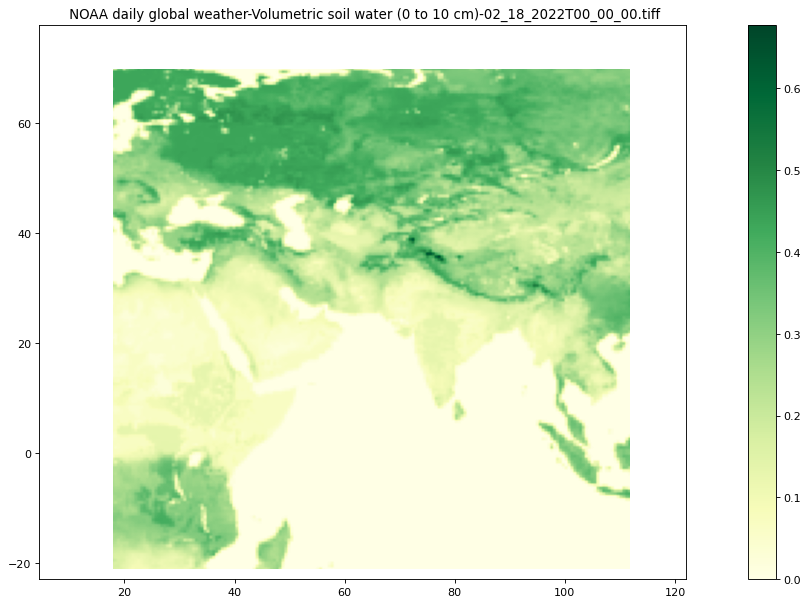

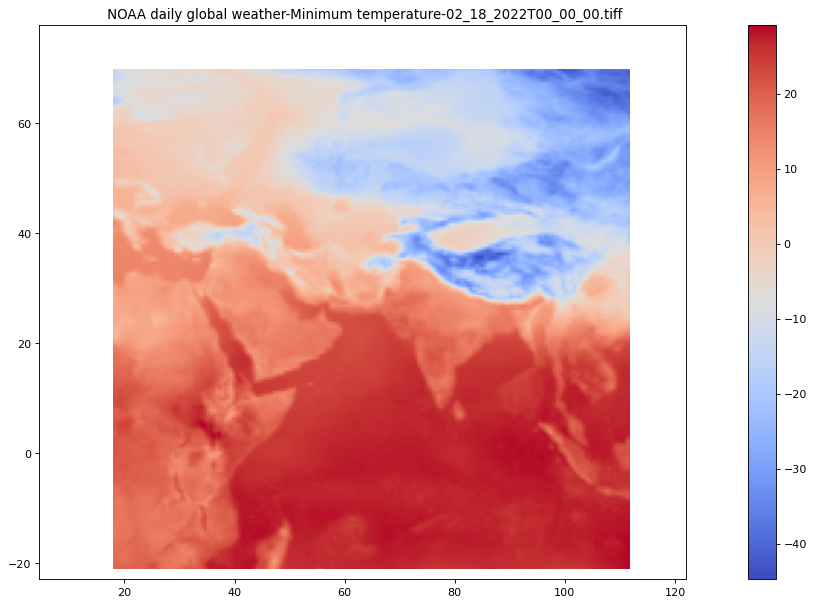

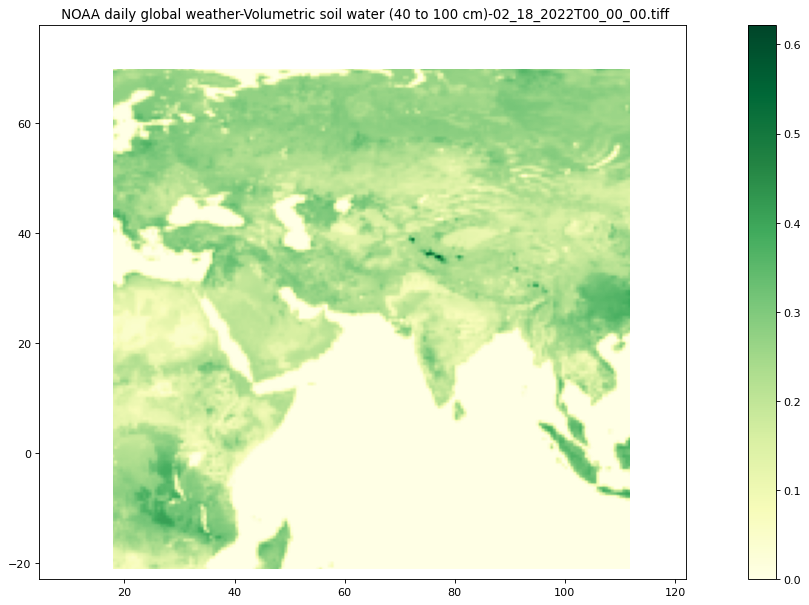

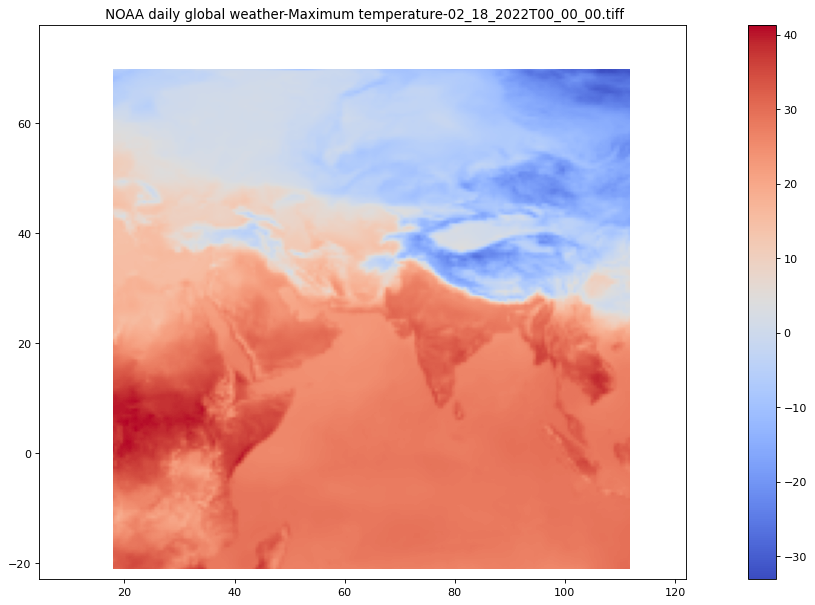

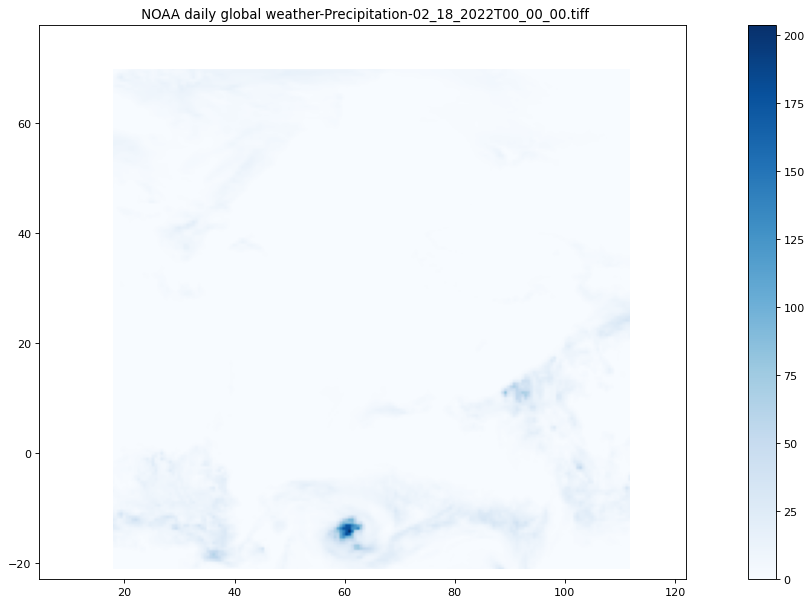

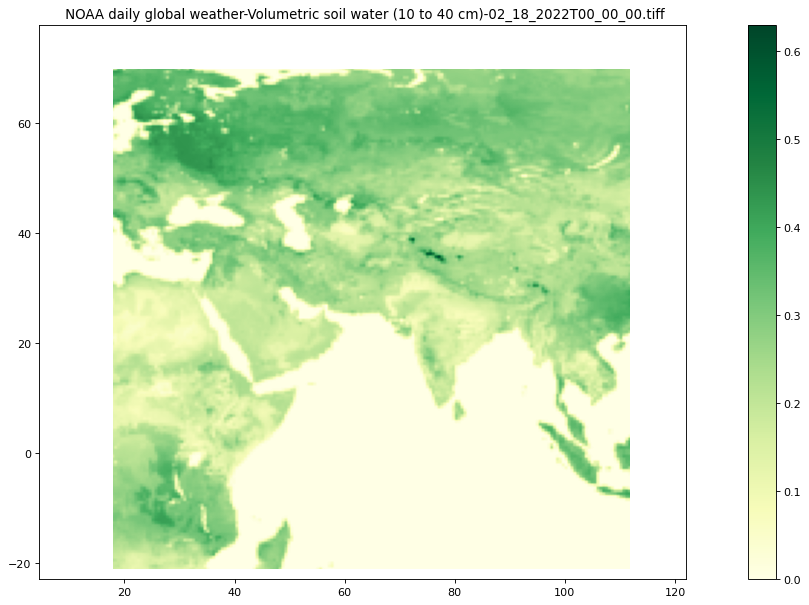

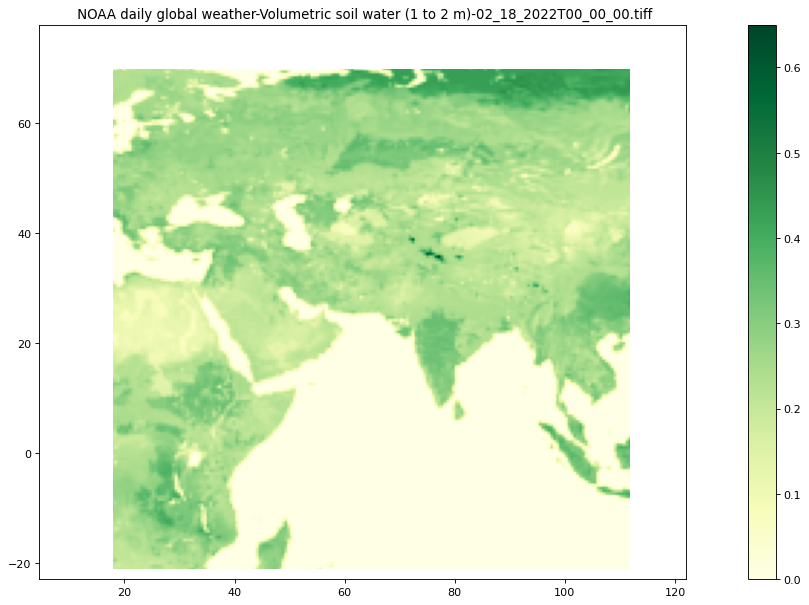

In [52]:
from IPython.display import Image

for output_image in output_image_array:
    # display the raster images
    display(Image(output_image, width=600, height=300))

The raster images above represent global weather data for daily maximum and minimum temperatures, precipitation, and volumetric soil water content at various soil depths (0–10 cm, 1–2 m, 10–40 cm, 40–100 cm)


### References

- https://source.coop/repositories/dynamical/noaa-gfs-analysis-hourly/description
- https://www.emc.ncep.noaa.gov/emc/pages/numerical_forecast_systems/gfs.php
